#### PHYS591000 in 2022
# Lab 13
---
## Introduction 
In lab 13, we will practice GAN.  
* Build a Generative Adversarial Network(GAN)
* Learn GAN structure  
* Generate the fake images of neurons.  

> **Useful Reference**
> 1. [GAN Introduction](https://medium.com/%E9%9B%9E%E9%9B%9E%E8%88%87%E5%85%94%E5%85%94%E7%9A%84%E5%B7%A5%E7%A8%8B%E4%B8%96%E7%95%8C/%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-ml-note-generative-adversarial-network-gan-%E7%94%9F%E6%88%90%E5%B0%8D%E6%8A%97%E7%B6%B2%E8%B7%AF-c672125af9e6)
> 2. [GAN in wiki](https://en.wikipedia.org/wiki/Generative_adversarial_network)
> 3. [A Gentle Introduction to Generative Adversarial Networks (GANs)](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/)

---
## Data Introduction  
[FlyCircuit](http://www.flycircuit.tw/)  
* Format: pickle file
* Each neuron has three kinds of wieghts.  
* Each weight has three 64x64 figures for three views.  
---

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Lab 13
---

### 1.0   

**Please just run these two cell to set up the enviroment.**

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

### 1.1 Load Data and preprocessing  
* Load all the data in the dataset.  
* Pick up figure 1(index 1) in `unit` weight in each file.  
* Transform `-1` to `0` for each figure.  
* Print out the data structure.  
* Flatten the data.  
* Print out the data structure again.  
`* Don't forget to normalize.`

In [3]:
##############################################################################
# Code for 1.1
# 
##############################################################################
# Please code in this cell
import pickle

dataset_ = np.zeros((64,64,), dtype='int8')

for filename in os.listdir('/kaggle/input/phys591000-2022-week12/fc_data'):
    
    with open('/kaggle/input/phys591000-2022-week12/fc_data/'+filename, 'rb') as f:
        data = pickle.load(f)
        
    dataset_ = np.dstack([dataset_, data['unit'][1,:,:]])
    
dataset = np.delete(dataset_, [0], 2)
print(f"The data shape after pick up is: {dataset.shape}")

reshape_data = dataset.reshape(4096,5000)
print(f"The data shape after flatten() is: {reshape_data.shape}")

reshape_data = (reshape_data+1)/2
##############################################################################

The data shape after pick up is: (64, 64, 5000)
The data shape after flatten() is: (4096, 5000)


### 1.2 Build the Generator  
* Set initial weight  
    * w_init = tf.truncated_normal_initializer(mean=0, stddev=0.02)  
    * b_init = tf.constant_initializer(0.)  
* Build up layers
    * example of layer: G_w0 = tf.get_variable()  
        --> G_b0 = tf.get_variable()  
        --> G_fc0 = tf.nn.relu(tf.matmul() + G_b0)  
    * Total 4 layers: input 100;output 256  
        --> input 256;output 1024  
        --> input 1024;output 2048  
        --> input 2048;output 4096  
    * The output layer should use `tanh` to be activation function.

In [4]:
##############################################################################
# Code for 1.2
# 
##############################################################################
# Please code in this cell

#Create Generator
def generator(z, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):
        # initializers
        w_init = tf.truncated_normal_initializer(mean=0, stddev=0.02)
        b_init = tf.constant_initializer(0.)

        # 1st hidden layer
        G_w0 = tf.get_variable('G_w0', [100, 256], initializer=w_init)
        G_b0 = tf.get_variable('G_b0', [256], initializer=b_init)
        G_fc0 = tf.nn.relu(tf.matmul(z, G_w0) + G_b0)

        # 2nd hidden layer
        G_w1 = tf.get_variable('G_w1', [256, 1024], initializer=w_init)
        G_b1 = tf.get_variable('G_b1', [1024], initializer=b_init)
        G_fc1 = tf.nn.relu(tf.matmul(G_fc0, G_w1) + G_b1)

        # 3rd hidden layer
        G_w2 = tf.get_variable('G_w2', [1024, 2048], initializer=w_init)
        G_b2 = tf.get_variable('G_b2', [2048], initializer=b_init)
        G_fc2 = tf.nn.relu(tf.matmul(G_fc1, G_w2) + G_b2)

        # output hidden layer
        G_w3 = tf.get_variable('G_w3', [2048, 4096], initializer=w_init)
        G_b3 = tf.get_variable('G_b3', [4096], initializer=b_init)
        f_image = tf.nn.tanh(tf.matmul(G_fc2, G_w3) + G_b3)

    return f_image

##############################################################################

### 1.3 Build the Discriminator  
* Set initial weight  
    * w_init = tf.truncated_normal_initializer(mean=0, stddev=0.02)  
    * b_init = tf.constant_initializer(0.)  
* Build up layers
    * example of layer: D_w0 = tf.get_variable()  
        --> D_b0 = tf.get_variable()  
        --> D_fc0 = tf.nn.relu(tf.matmul() + D_b0)  
        --> D_fc0 = tf.nn.dropout(D_fc0, drop_out)  
    * Total 4 layers: input 4096;output 2048   
        --> input 2048;output 1024  
        --> input 1024;output 256  
        --> input 256;output 1  
    * The output layer should use `sigmoid` to be activation function and no dropout.  

In [5]:
##############################################################################
# Code for 1.3
# 
##############################################################################
# Please code in this cell

# Create discriminator
def discriminator(image, drop_out, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # initializers
        w_init = tf.truncated_normal_initializer(mean=0, stddev=0.02)
        b_init = tf.constant_initializer(0.)

        # 1st hidden layer
        D_w0 = tf.get_variable('D_w0', [4096, 2048], initializer=w_init)
        D_b0 = tf.get_variable('D_b0', [2048], initializer=b_init)
        D_fc0 = tf.nn.relu(tf.matmul(image, D_w0) + D_b0)
        D_fc0 = tf.nn.dropout(D_fc0, drop_out)

        # 2nd hidden layer
        D_w1 = tf.get_variable('D_w1', [2048, 1024], initializer=w_init)
        D_b1 = tf.get_variable('D_b1', [1024], initializer=b_init)
        D_fc1 = tf.nn.relu(tf.matmul(D_fc0, D_w1) + D_b1)
        D_fc1 = tf.nn.dropout(D_fc1, drop_out)

        # 3rd hidden layer
        D_w2 = tf.get_variable('D_w2', [1024, 256], initializer=w_init)
        D_b2 = tf.get_variable('D_b2', [256], initializer=b_init)
        D_fc2 = tf.nn.relu(tf.matmul(D_fc1, D_w2) + D_b2)
        D_fc2 = tf.nn.dropout(D_fc2, drop_out)

        # output layer
        D_w3 = tf.get_variable('D_w3', [256, 1], initializer=w_init)
        D_b3 = tf.get_variable('D_b3', [1], initializer=b_init)
        output = tf.sigmoid(tf.matmul(D_fc2, D_w3) + D_b3)

        return output

##############################################################################

### 1.4 Define a figure output function  
* Define a function to save the fake images the generator made.  
* We will generate 16 images a time, so you can subplot them into a picture.  

In [6]:
##############################################################################
# Code for 1.4
# 
##############################################################################
# Please code in this cell

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# save image
def save_f_image(index, z_sample):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(z_sample):  # [i,samples[i]] imax=16
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(64, 64), cmap='gray')
    plt.savefig('{}.png'.format(str(index).zfill(3)), bbox_inches='tight')
    plt.close(fig)

##############################################################################

### 1.5 Set up for training  
* Input placeholder for float32  
    * x for real, shape=(None, 4096).  
    * z for fake, shape=(None, 100).  
    * drop out.  
* Generate fake image and discriminate real and fake.  
* Calculate loss for generator and discriminator.  
    * eps = 1e-2  
    * D_loss = tf.reduce_mean(-tf.log(D_real + eps) - tf.log(1 - D_fake + eps))  
    * G_loss = tf.reduce_mean(-tf.log(D_fake + eps))  
* Trainable variables for each network.  
    * `t_vars = tf.trainable_variables()`  
* Optimizer for generator and discriminator.  
    * tf.train.AdamOptimizer(l_rate=0.0002)  

In [7]:
##############################################################################
# Code for 1.5
# 
##############################################################################
# Please code in this cell

#
# 1. Input placeholder for float32
#
x = tf.placeholder(tf.float32, shape=(None, 4096))    # x is for feeding input images to the discriminator
z = tf.placeholder(tf.float32, shape=(None, 100))     # z is for feeding input noise to the generator
drop_out = tf.placeholder(tf.float32)


#
# 2. Generate fake image and discriminate real and fake.
#
#####
f_sample = generator(z)
D_real = discriminator(x, drop_out)
D_fake = discriminator(f_sample,drop_out,reuse=True)


#
# 3. Calculate loss for generator and discriminator.
#
eps = 1e-2
D_loss = tf.reduce_mean(-tf.log(D_real+ eps) - tf.log(1. -D_fake+ eps))
G_loss = tf.reduce_mean(-tf.log(D_fake+ eps))


#
# 4. Trainable variables for each network
#
# Get the varaibles for different network
t_vars = tf.trainable_variables()
D_vars = [var for var in t_vars if 'D_' in var.name]
G_vars = [var for var in t_vars if 'G_' in var.name]


#
# 5. Optimizer for generator and discriminator.
#
D_train =tf.train.AdamOptimizer(0.0002).minimize(D_loss, var_list = D_vars)
G_train = tf.train.AdamOptimizer(0.0002).minimize(G_loss, var_list = G_vars)
##############################################################################

### 1.6 Train  
* Set hyperparameters  
    * batch_size = 100  
    * l_rate = 0.0002  
    * train_epoch = 500  
    * epoch = 0  
    * index = 0  
* Setup tensorflow session  
    * tf.GPUOptions(allow_growth=True)  
    * tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))  
    * tf.global_variables_initializer()  
    * tf.train.Saver()  
* Default noise  
    * Create the noise to be input data.  
* Start training and save model.  
* Save the generated images.  

In [8]:
##############################################################################
# Code for 1.6
# 
##############################################################################
# Please code in this cell



#Set Hyper paramatrics
batch_size = 100
l_rate = 0.0002
index = 0

gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

init = tf.global_variables_initializer()
sess.run(init)

saver = tf.train.Saver()

##############################################################################

2022-05-12 09:16:14.137606: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-12 09:16:14.193134: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 09:16:14.318989: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 09:16:14.320112: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [9]:
epoch = 0
train_epoch = 500


train_set = np.swapaxes(reshape_data,0,1)

test_z = np.random.normal(0, 1, (16, 100))

G_losslist = []
D_losslist = []

while epoch <= train_epoch:
    G_losses =[]
    D_losses =[]
    #sess.graph.finalize()
    if epoch % 1 == 0:
        fake_image = sess.run(f_sample, {z: test_z, drop_out: 0.0})
        save_f_image(index, fake_image)
        index +=1

    for i in range(0, train_set.shape[0],batch_size):
        sess.graph.finalize()
        input_x = train_set[i:i + batch_size]
        input_z = np.random.normal(0,1,(batch_size,100))

        sess.run(D_train,{x:input_x, z:input_z, drop_out:0.3})
        loss_d = sess.run(D_loss,{x:input_x, z:input_z, drop_out:0.3})
        D_losses.append(loss_d)

#         input_z = np.random.normal(0,1,(batch_size,100))

        sess.run(G_train, {z: input_z, drop_out: 0.3})
        loss_g = sess.run(G_loss, {z: input_z, drop_out: 0.3})
        G_losses.append(loss_g)
        #print("epoch of {}, batch {} ~ {}, D_loss: {}, G_loss: {} ".format(epoch+1,i,i+batch_size,loss_d,loss_g))
        #print("epoch of {}, batch {} ~ {}, D_loss: {}, G_loss: {} ".format(epoch+1,i,i+batch_size,loss_d,loss_g))
    print("@epoch of {}, D_loss: {}, G_loss: {}".format(epoch+1,np.mean(D_losses),np.mean(G_losses)))
    G_losslist.append(np.mean(G_losses))
    D_losslist.append(np.mean(D_losses))

    epoch += 1
    
    
#Save model
save_path = saver.save(sess, "GANmodel.ckpt")
print("Model saved in path: %s" % save_path)

@epoch of 1, D_loss: 0.5975018739700317, G_loss: 1.1717462539672852
@epoch of 2, D_loss: 0.5193248391151428, G_loss: 0.944074273109436
@epoch of 3, D_loss: 0.4324687719345093, G_loss: 1.4170820713043213
@epoch of 4, D_loss: 0.28634607791900635, G_loss: 1.7614036798477173
@epoch of 5, D_loss: 0.17776809632778168, G_loss: 3.004138708114624
@epoch of 6, D_loss: 0.302313894033432, G_loss: 3.8399767875671387
@epoch of 7, D_loss: 0.384078711271286, G_loss: 3.1870815753936768
@epoch of 8, D_loss: 0.3589070439338684, G_loss: 3.531371831893921
@epoch of 9, D_loss: 0.24984708428382874, G_loss: 2.783292293548584
@epoch of 10, D_loss: 0.1931108683347702, G_loss: 2.795449733734131
@epoch of 11, D_loss: 0.20651450753211975, G_loss: 2.5873467922210693
@epoch of 12, D_loss: 0.18105441331863403, G_loss: 3.525268793106079
@epoch of 13, D_loss: 0.32869023084640503, G_loss: 3.5810396671295166
@epoch of 14, D_loss: 0.024887843057513237, G_loss: 4.301568984985352
@epoch of 15, D_loss: 0.06800747662782669, G

### 1.7 Plot the learning curve  
* Plot the loss curve.  

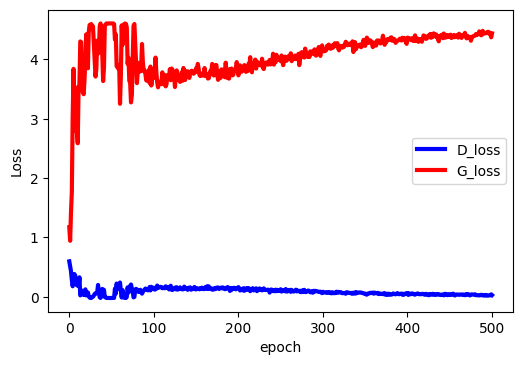

In [10]:
##############################################################################
# Code for 1.7
# 
##############################################################################
# Please code in this cell

fig = plt.figure(figsize=(6,4), dpi = 100)
plt.plot(D_losslist, lw=3, label='D_loss', color='blue')
plt.plot(G_losslist, lw=3, label='G_loss', color='red')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##############################################################################

### 1.8 Visualize the fake images  
* Pick up the first and last images you saved.  
* Show the images.  

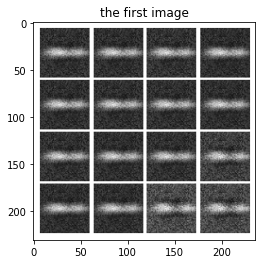

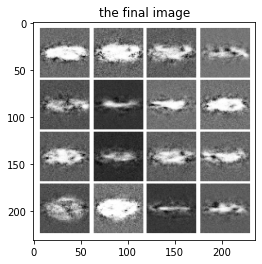

In [13]:
##############################################################################
# Code for 1.8
# 
##############################################################################
# Please code in this cell


import matplotlib.image as img

image1 = img.imread('019.png')
plt.title("the first image")
plt.imshow(image1)
plt.show()

image2 = img.imread('494.png')
plt.title("the final image")
plt.imshow(image2)
plt.show()

##############################################################################

### 1.9
Discussion for 1.7 and 1.8

According to the loss curve and the images, please try your best to commnet on the performance of this GAN.  

`Please describe your opinion that why the performance looks like that.`
`Please write down the meaning of loss curve, generated images and the relationship between them.`
`Please compare with the AE last week.`

---
Please write your discussion in this cell:     


The loss curve of discriminator(D_loss) represent the loss between 1 to the result after input fake image to discriminator + 0 to the result after input real image to discriminator. We expect that we can get less D_loss to make sure discriminator can determine the true/fake image; The loss curve of generator(G_loss) only represent the loss between 1 to the result after input fake image to generator. We consider the G_loss will be a higher value to generate a fake enough image.<br>

Before epoch go over 10, the discriminator and generator are initially start to be trained, so during that time the loss of what they have is quitely closed. After loop go through, they sucessfully train and start to let loss become closed to 0 and larger to some value. The generated images also see they have a obviously different between the previous training one.<br>

Compare to the last week, AE structure main goal is to enlarge the freature during encode progress and then keep those features in decode step; GAN strucure use the two opposite function to let the model can be max training. 